# Spin-polarised current driven skyrmion

**Author**: Marijan Beg,  Weiwei Wang

**Date**: 30 July 2016

This notebook can be downloaded from the github repository, found [here](https://github.com/computationalmodelling/fidimag/blob/master/doc/ipynb/spin-polarised-current-driven-skyrmion.ipynb).

In this tutorial, a single magnetic skyrmion is driven by a spin-polarised current.

Firstly, we define a function which will be subsequently used for plotting the z component of magnetisation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_magnetisation(m, mesh, title=None):
    m.shape = (-1, 3)
    mx = m[:, 0]
    my = m[:, 1]
    mz = m[:, 2]
    nx, ny = mesh.nx, mesh.ny
    mx.shape = (ny, nx)
    my.shape = (ny, nx)
    mz.shape = (ny, nx)
    

    #plt.imshow(mz, extent=extent)
    #plt.xlabel('x (nm)')
    #plt.ylabel('y (nm)')
    
    
    fig = plt.figure(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.quiver(mx[::3,::3], my[::3,::3], mz[::3,::3], pivot='mid', alpha=0.9, scale=18, width=0.005,  cmap=plt.get_cmap('jet'), edgecolors='None' )
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Now, we create a finite difference mesh.

In [2]:
from fidimag.micro import Sim
from fidimag.common import CuboidMesh
from fidimag.micro import Zeeman, Demag, DMI, UniformExchange

mesh = CuboidMesh(nx=51, ny=30, nz=1, dx=2.5, dy=2.5, dz=2, unit_length=1e-9, periodicity=(True, True, False))

We create a simulation object that contains uniform exchange, DMI, and Zeeman energy contributions.

In [3]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
Ms = 8.6e5  # magnetisation saturation (A/m)
A = 1.3e-11  # exchange stiffness (J/m)
D = 4e-3  # DMI constant (J/m**2)
H = (0, 0, 3.8e5)  # external magnetic field (A/m)
alpha = 0.5  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio (m/As)

sim  = Sim(mesh)  # create simulation object

# Set parameters.
sim.Ms = Ms
sim.driver.alpha = alpha
sim.driver.gamma = gamma
sim.driver.do_precession = False

# Add energies.
sim.add(UniformExchange(A=A))
sim.add(DMI(D))
sim.add(Zeeman(H))

In order to get a skyrmion as a relaxed state, we need to initialise the system in an appropriate way. For that, we use the following function, and plot the initial state.

In [4]:
def m_initial(coord):
    # Extract x and y coordinates.
    x = coord[0]
    y = coord[1]
    
    # The centre of the circle
    x_centre = 15*2.5
    y_centre = 15*2.5
    
    # Compute the circle radius.
    r = ((x-x_centre)**2 + (y-y_centre)**2)**0.5
    
    if r < 8.0:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
sim.set_m(m_initial)

Now, we can relax the system, save and plot the relaxed state.

In [5]:
%%capture
sim.driver.relax(dt=1e-13, stopping_dmdt=0.1, max_steps=5000, save_m_steps=None, save_vtk_steps=None)
np.save('m0.npy', sim.spin)

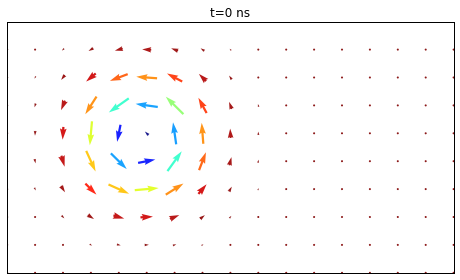

In [6]:
plot_magnetisation(sim.spin.copy(), mesh, title='t=0 ns')

Using the obtained relaxed state, we create a new smulation object and specify the driver to be 'llg_stt'. By applying a spin-polarised current of $J = 5 \times 10^{12} \,\text{A/m}^{2}$ in the $x$ directions with $\beta = 0.2$, we move a skyrmion in the simulated sample.

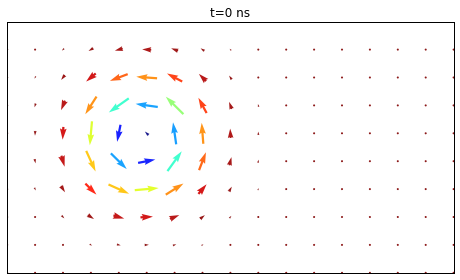

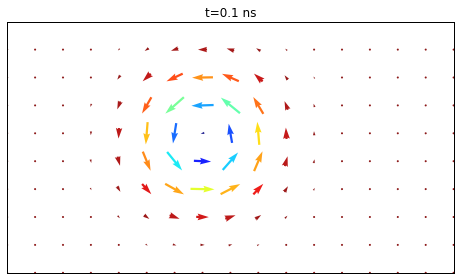

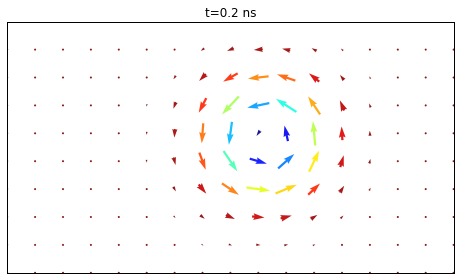

In [7]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
sim2  = Sim(mesh, driver='llg_stt')  # create simulation object

# Set parameters.
sim2.Ms = Ms
sim2.alpha = alpha
sim2.driver.gamma = gamma

# Add energies.
sim2.add(UniformExchange(A=A))
sim2.add(DMI(D))
sim2.add(Zeeman(H))

sim2.driver.jx = -5e12
sim2.alpha = 0.2
sim2.driver.beta = 0.2

sim2.set_m(np.load('m0.npy'))

for t in [0, 0.1, 0.2]:
    sim2.driver.run_until(t*1e-9)
    plot_magnetisation(sim2.spin.copy(), mesh, title='t=%g ns'%t)